IN THIS DOCUMENT...

I will test the preprocessing and visualize the data that we are working with. It is meant a support document to utilize if we want to quickly check the data preprocessing and final database

First... Import statements!

In [1]:
import os
import pandas as pd
import numpy as np
import json
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
import shap
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer



C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For the unofficial database that we have from Kaggle there is already some preprocessing developed so we will use it for a first preprocessing before harmonization and differentiation.

This data comes from three sources:

- Reader_data: Glucose extracts for each week for one user. Contains: Historic Glucose, Scan Glucose, Record Type, Time, ID, Non-nummeric Rapid-Acting Insulin, Rapid-Active Insulin, Non-numeric Food, Carbohydrates, Non-numeric Long-Acting Insulin, Long-Acting Insulin,Note, Strip Glucose, Ketone, Meal Insulin, Correction Insulin, User change Insulin, Previous Time and Updated Time.

But I am only interested in extracting: Time, Historic Glucose, Rapid-Acting Insulin and Long-Acting Insulin.

Since the Scan Glucose has a lot of missing values and Historic Glucose has exactly one record for each 15 minutes intervals (not necessarily taken every 15 minutes but somewhere in the 15 minutes window) I believe it is better to focus on the Historic Glucose Data.

- MySugr_data: It is the data about the meals of the user and contains: Date, Time, Tags, Blood Sugar Measurement, Insulin Injection Units, Basal Injection Units, Insulin Injection Units pump, Insulin of meal, Insulin correction, Temproal Basal Percentage, Temporal basal duration, Meal Carbohydrates, Meal description, Activity Duration, Activity Intensity, Activity description, Steps, Note, Location, Blood Pressure, Body weight, HbA1c, Ketones, Food type and medication.

I am only going to extract: Time and Meal carbohydrates

- fitbit_data: Data from a fitbit band monitoring it contains personal account, physical activity, sleep and stress. I will personally focus first on extracting physical activity and stress.

From these I will use the values of: Time, BPM, total_minutes, distance and calories. And from stress just the subjective stress score as indicated by the user.



In [2]:

# Initialize df_combined outside of the functions
df_combined = pd.DataFrame()

def load_reader_dataset():
    # Specify the path for reader data
    reader_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/reader_data"
    exports = [os.path.join(reader_data, export) for export in os.listdir(reader_data)]
    exports.sort(reverse=False)

    df = pd.read_csv(exports[0], sep="\t")
    for export in exports[1:]:
        df = pd.concat([df, pd.read_csv(export, sep="\t")])

    # Exports usually overlap, so drop the duplicates
    df.drop_duplicates(inplace=True)

    # Dropping columns that are not needed
    df.drop(['Non-numeric Food', 'Non-numeric Long-Acting Insulin','Strip Glucose (mmol/L)','Scan Glucose (mmol/L)','Previous Time', 'Updated Time', 'Non-numeric Rapid-Acting Insulin',
             'Notes', 'Ketone (mmol/L)', 'User Change Insulin (units)', 'Record Type','Correction Insulin (units)','Carbohydrates (grams)', 'ID', 'Meal Insulin (units)'],
            axis=1, inplace=True)

    df.rename(columns={'Rapid-Acting Insulin (units)': 'Rapid Insulin',
                       'Long-Acting Insulin (units)': 'Long Insulin'},
              inplace=True)

    df['Time'] = pd.to_datetime(df['Time'], format="%Y/%m/%d %H:%M")
    df.sort_values(by='Time', inplace=True)

    # Only considering Historical Glucose (reliable 15min measurements) - we're not using Scan Glucose column
    df.rename(columns={'Historic Glucose (mmol/L)': 'Glucose'}, inplace=True)

    # Since 2022/01/09 00:00 we use mySugr to keep track of insulin and Carbohydrates, so drop any data after this date
    df.loc[df['Time'] >= "2022/01/09 00:00", ['Rapid Insulin', 'Long Insulin']] = np.nan

    global df_combined
    df_combined = pd.concat([df_combined, df], ignore_index=True)
    return df


def load_mySugr_dataset():
    mySugr_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/mySugr_data/2022_01_09-2022_04_25_export.csv"
    mysugr_df = pd.read_csv(mySugr_data, sep=",")

    # Keeping only the relevant columns
    mysugr_df = mysugr_df[['Date', 'Time', 'Meal Carbohydrates (Grams, Factor 1)']]

    mysugr_df.rename(columns={'Meal Carbohydrates (Grams, Factor 1)': 'Carbohydrates'}, inplace=True)

    mysugr_df["Time"] = pd.to_datetime(mysugr_df["Date"] + " " + mysugr_df["Time"], format="%b %d, %Y %I:%M:%S %p")
    mysugr_df.sort_values(by='Time', inplace=True)
    mysugr_df.drop(['Date'], axis=1, inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, mysugr_df], ignore_index=True)
    return mysugr_df


def read_fitbit_json_export(export_file, export_type):
    with open(export_file, "r") as f:
        j = json.load(f)
    df_read = pd.json_normalize(j)
    df_read["dateTime"] = pd.to_datetime(df_read["dateTime"], format="%m/%d/%y %H:%M:%S")

    if export_type == "heart":
        df_read.rename(columns={"value.bpm": "bpm"}, inplace=True)
        df_read.drop("value.confidence", axis=1, inplace=True)
    elif export_type == "calories":
        df_read.rename(columns={"value": "calories"}, inplace=True)
        df_read["calories"] = df_read["calories"].astype(float)
    elif export_type == "distance":
        df_read.rename(columns={"value": "distance"}, inplace=True)
        df_read["distance"] = df_read["distance"].astype(int)
        # Convert from centimeters to meters
        df_read["distance"] = df_read["distance"] / 100
    else:
        raise Exception("Export type not recognized")
    
    return df_read


def load_fitbit_dataset():
    fitbit_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/fitbit_data/2022_04_25_all_time_export/Physical Activity"

    calories_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "calories" in export])
    distance_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "distance" in export])
    heart_rate_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "heart_rate-" in export and not "resting" in export])

    df_fitbit = read_fitbit_json_export(calories_exports[0], "calories")
    for export in calories_exports[1:]:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "calories")], ignore_index=True)
    for export in distance_exports:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "distance")], ignore_index=True)
    for export in heart_rate_exports:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "heart")], ignore_index=True)

    # Change to 1 minute frequency
    df_fitbit = df_fitbit.set_index('dateTime').resample('1T').agg(
        {'bpm': pd.Series.mean, 'distance': pd.Series.sum, 'calories': pd.Series.sum}).reset_index()

    df_fitbit.rename(columns={"dateTime": "Time"}, inplace=True)
    df_fitbit.sort_values(by='Time', inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, df_fitbit], ignore_index=True)
    return df_fitbit


def load_stressdata():
    stress_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/fitbit_data/2022_04_25_all_time_export/Stress/Stress Score.csv"
    stress_df = pd.read_csv(stress_data, sep=",")
    stress_df = stress_df[['UPDATED_AT', 'STRESS_SCORE']]

    stress_df.rename(columns={'STRESS_SCORE': 'Stress'}, inplace=True)

    stress_df['Time'] = stress_df['UPDATED_AT'].str.replace('T', ' ')
    stress_df['Time'] = pd.to_datetime(stress_df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

    stress_df.drop(['UPDATED_AT'], axis=1, inplace=True)
    stress_df.sort_values(by='Time', inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, stress_df], ignore_index=True)
    return stress_df


# Now you can call these functions to load and combine the data
load_reader_dataset()
load_mySugr_dataset()
load_fitbit_dataset()
load_stressdata()

# After calling these methods, df_combined will have all the datasets combined in one DataFrame.
print(df_combined)


                          Time  Glucose  Rapid Insulin  Long Insulin  \
0      2020-11-02 18:09:00.000      7.8            NaN           NaN   
1      2020-11-02 18:24:00.000      8.0            NaN           NaN   
2      2020-11-02 18:38:00.000      7.6            NaN           NaN   
3      2020-11-02 18:53:00.000      7.3            NaN           NaN   
4      2020-11-02 19:08:00.000      7.3            NaN           NaN   
...                        ...      ...            ...           ...   
266051 2022-04-21 09:58:44.073      NaN            NaN           NaN   
266052 2022-04-22 21:57:22.002      NaN            NaN           NaN   
266053 2022-04-23 10:25:39.922      NaN            NaN           NaN   
266054 2022-04-24 12:50:45.757      NaN            NaN           NaN   
266055 2022-04-25 07:34:26.828      NaN            NaN           NaN   

        Carbohydrates  bpm  distance  calories  Stress  
0                 NaN  NaN       NaN       NaN     NaN  
1                 NaN

In [3]:
df_combined.to_csv('preprocessing.csv',sep='\t', index=False )

After the Preprocessing the data looks as shown in the csv file called 'preprocessing.csv'...

There are 166067 rows indexed by time

There are 9 columns: Time, Glucose, Carbohydrates, Rapid Insulin, Long Insulin, bpm, distance, calories and Stress


*HARMONIZING*

Since the data is not collected at the same time moments and we want to do time series analysis we need to harmonize it. Since the most consistent data is the historic glucose and there is a value each 15 minutes, I will harmonize for 15 minute intervals.

HARMONIZING STRATEGIES:
-Glucose: There is just one value each 15 minutes since it is the historic glucose, so that is our value!
- Carbodyrates: Sum the carbs eaten in those 15 minutes
- Rapid Insulin: Sum the insulin injected in those 15 minutes
- Long Insulin: Sum the insulin injected in those 15 minutes
- bpm: Average the bpm in those 15 mintues
- distace: sum the distance in those 15 minutes
- calories: Sum the calories used in those 15 minutes
- stress: average the stress score from those registered within the 15 minutes window

In [14]:
import pandas as pd

# Assuming df_combined is already defined
temp = df_combined.copy()

start_time = "2021-11-21 23:45:00"  # Starting point
end_time = temp.index.max()  # Or set your desired end time

# Generate the time range
time_range = pd.date_range(start=start_time, end=end_time, freq='15T')
temp.set_index('Time', inplace=True)

# Resample the data for 15-minute intervals
df_glu = temp.resample('15T')['Glucose'].mean()
df_car = temp.resample('15T')['Carbohydrates'].sum()
df_rap = temp.resample('15T')['Rapid Insulin'].sum()
df_long = temp.resample('15T')['Long Insulin'].sum()
df_bpm = temp.resample('15T')['bpm'].mean()
df_calories = temp.resample('15T')['calories'].sum()
df_distance = temp.resample('15T')['distance'].sum()
df_st = temp.resample('15T')['Stress'].sum()

# Create a new DataFrame with the resampled data
df_har = pd.DataFrame({
    'Time': df_glu.index,
    'Glucose': df_glu,
    'Carbohydrates': df_car,
    'Rapid Insulin': df_rap,
    'Long Insulin': df_long,
    'BPM': df_bpm,
    'Calories': df_calories,
    'Distance': df_distance,
    'Stress': df_st
})
# Convert Time column to datetime if needed
df_har['Time'] = pd.to_datetime(df_har['Time'])

# 1️⃣ Select first month (e.g., December 2021)
first_month_mask = (df_har['Time'] >= '2021-12-01') & (df_har['Time'] < '2022-01-01')
df_first = df_har[first_month_mask].reset_index(drop=True)

# 2️⃣ Select third month (e.g., February 2022) only for Carbs + BPM
third_month_mask = (df_har['Time'] >= '2022-02-01') & (df_har['Time'] < '2022-03-01')
df_third = df_har[third_month_mask][['Carbohydrates', 'BPM']].reset_index(drop=True)

# 3️⃣ Ensure both have the same length (cut to shortest)
min_len = min(len(df_first), len(df_third))
df_first = df_first.iloc[:min_len]
df_third = df_third.iloc[:min_len]

# 4️⃣ Replace carbs + bpm in first month with those from third
df_first['Carbohydrates'] = df_third['Carbohydrates'].values
df_first['BPM'] = df_third['BPM'].values

# 5️⃣ Final dataframe
df = df_first.copy()


Lets fill in the missing data with Linear Regression

Let's do some quick visualization with matplotlib

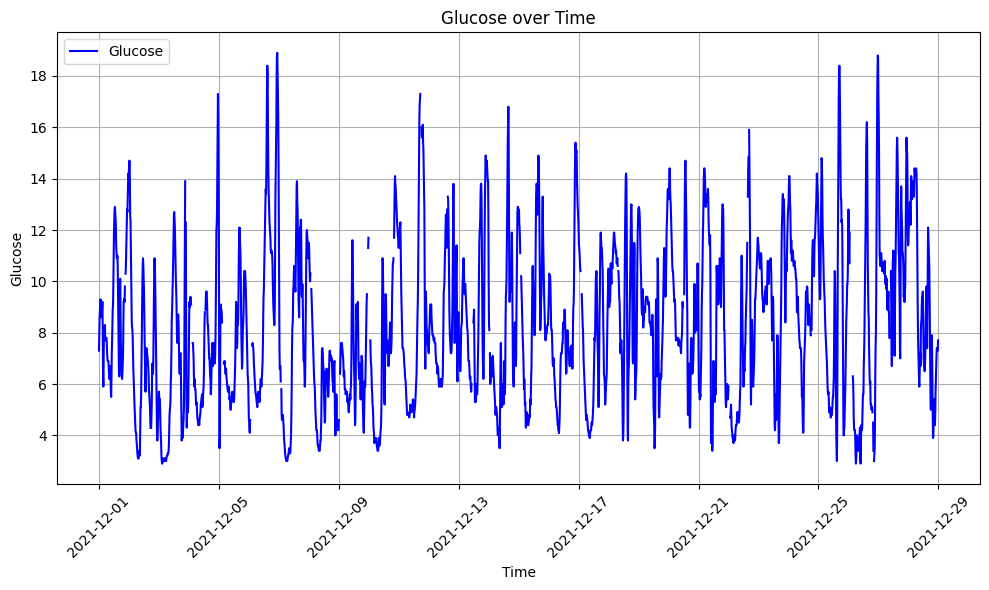

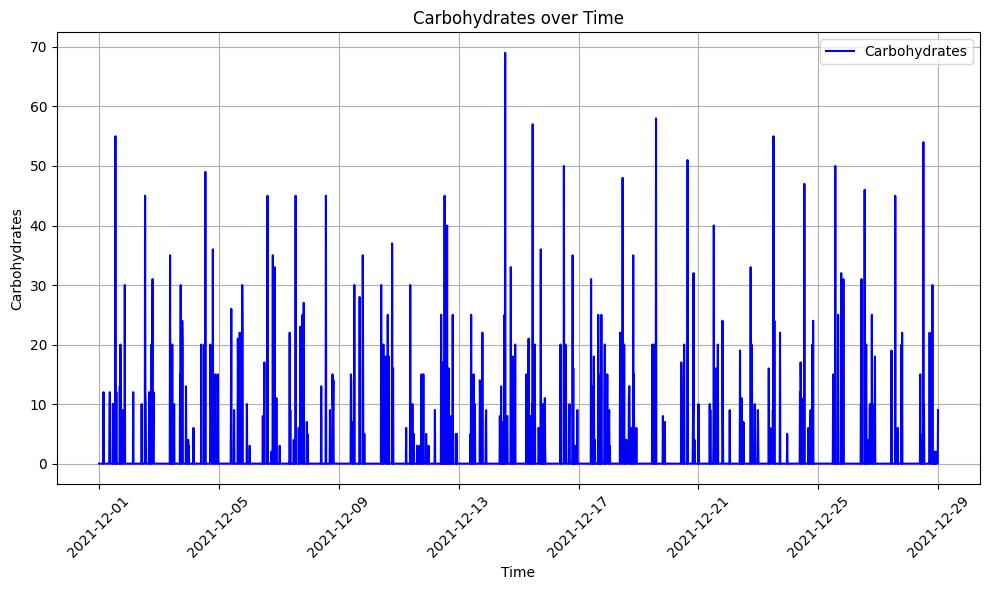

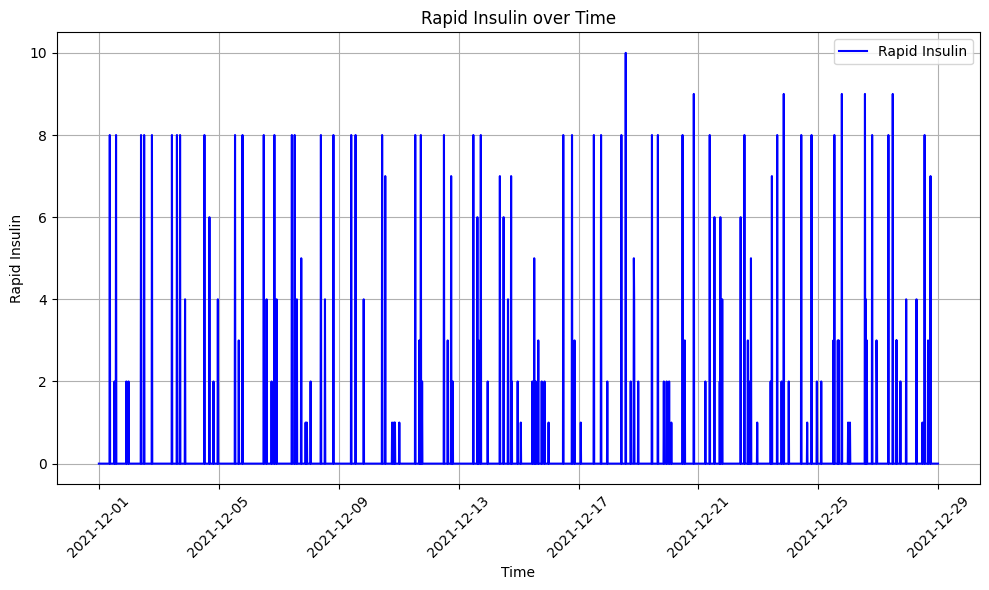

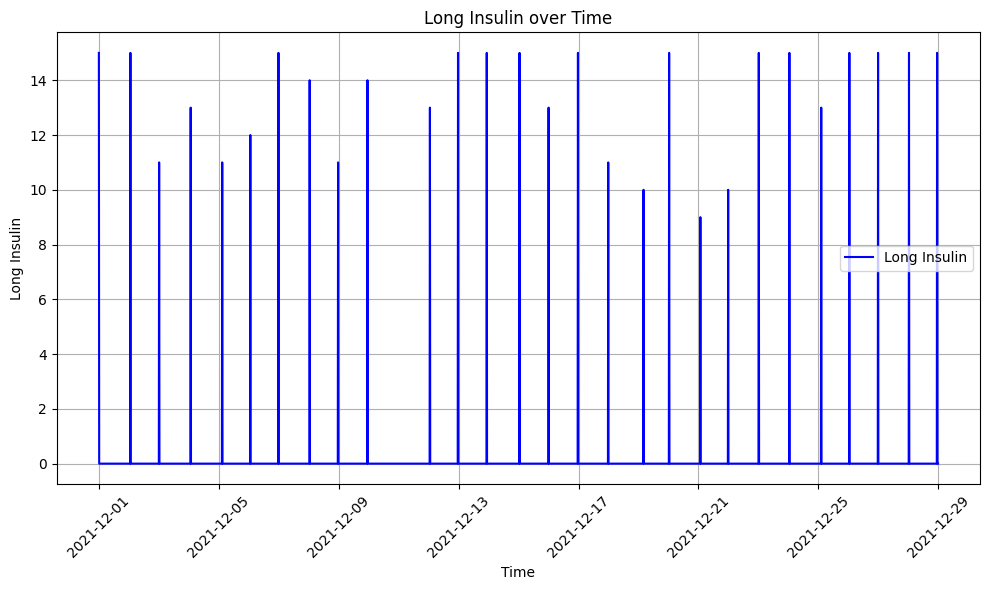

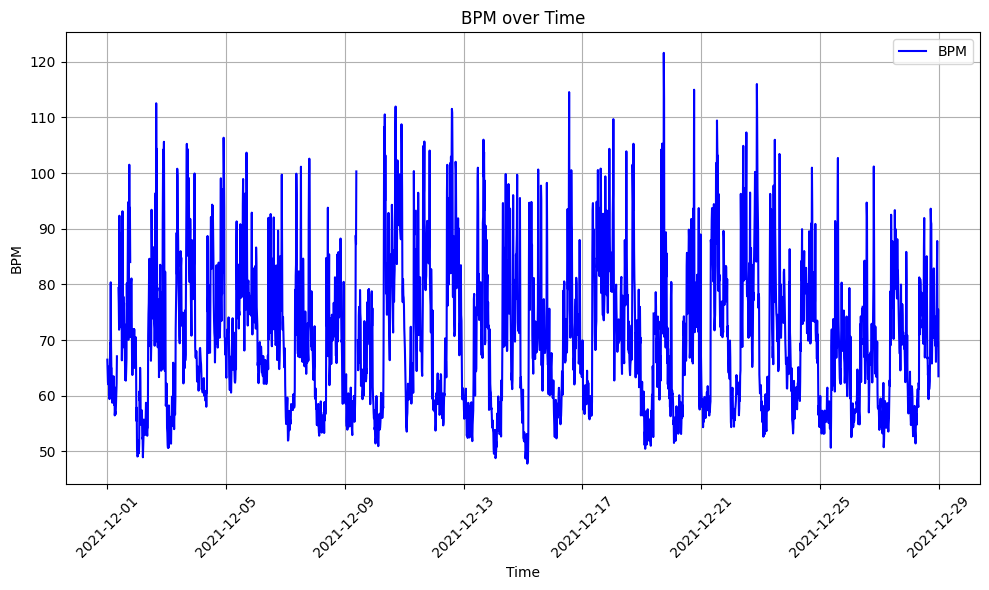

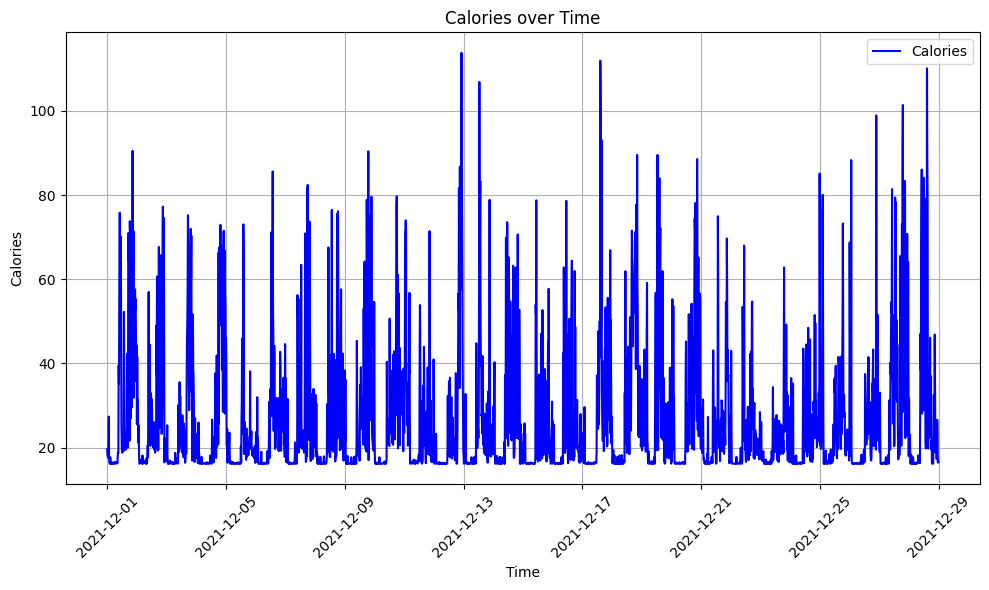

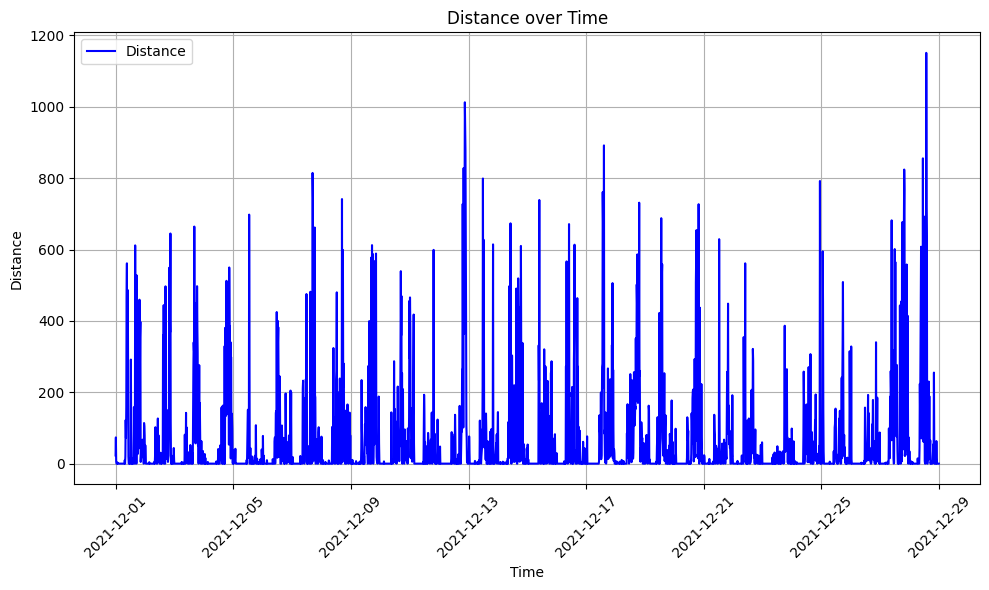

In [20]:

# Define the columns you want to plot
columns_to_plot = ['Glucose','Carbohydrates', 'Rapid Insulin', 'Long Insulin', 'BPM', 'Calories', 'Distance']

# Create a plot for each column
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
    plt.plot(df['Time'], df[column], label=column, color='b')  # Plot the data
    plt.title(f'{column} over Time')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Now we do the kinetics for insulin and carbohydrates and save it in kinetics csv file and the final dataframe called DF.

In [38]:
# Copy your harmonized DataFrame
df_kinetics = df.copy()

# Use the real length from your actual dataset
steps = len(df_kinetics)
dt = 1  # assumed 1-minute interval between rows

# Extract injection data from the dataframe
rapid_injection = df_kinetics['Rapid Insulin'].fillna(0).values
long_injection = df_kinetics['Long Insulin'].fillna(0).values

# Define absorption model
def insulin_absorption_model(rapid_array, long_array, ka1_r=0.04, ka2_r=0.06, ka1_l=0.01, ka2_l=0.015):
    Q1_r = np.zeros(steps)
    Q2_r = np.zeros(steps)
    Q1_l = np.zeros(steps)
    Q2_l = np.zeros(steps)

    for i in range(1, steps):
        inj_r = rapid_array[i]
        inj_l = long_array[i]

        dQ1_r = (-ka1_r * Q1_r[i-1] + inj_r) * dt
        dQ2_r = (ka1_r * Q1_r[i-1] - ka2_r * Q2_r[i-1]) * dt

        dQ1_l = (-ka1_l * Q1_l[i-1] + inj_l) * dt
        dQ2_l = (ka1_l * Q1_l[i-1] - ka2_l * Q2_l[i-1]) * dt

        Q1_r[i] = Q1_r[i-1] + dQ1_r
        Q2_r[i] = Q2_r[i-1] + dQ2_r

        Q1_l[i] = Q1_l[i-1] + dQ1_l
        Q2_l[i] = Q2_l[i-1] + dQ2_l

    return Q2_r + Q2_l  # Insulin on board = sum of both compartments

# Apply model and store result in new column
df_kinetics['Insulin on board'] = insulin_absorption_model(rapid_injection, long_injection)
df_kinetics['Insulin absorption'] = insulin_absorption_model(rapid_injection, long_injection)


In [39]:
def carbs_to_cob(df, carb_col='Carbohydrates', dt=15, t_max=40):
    Q1 = np.zeros(len(df))
    Q2 = np.zeros(len(df))
    
    for i in range(1, len(df)):
        # Take carbs from previous step — they happen *before* absorption starts
        c = df.iloc[i - 1][carb_col]
        
        dQ1 = (-Q1[i - 1] / t_max) * dt + 0.8 * c

        dQ2 = (Q1[i - 1] / t_max - Q2[i - 1] / t_max) * dt



        Q1[i] = Q1[i - 1] + dQ1
        Q2[i] = Q2[i - 1] + dQ2

    df['COB'] = Q2
    return df


df_kinetics = carbs_to_cob(df_kinetics)

In [40]:
# Ensure datetime is sorted
df_kinetics = df_kinetics.sort_values('Time').reset_index(drop=True)

# Create new columns
df_kinetics['Minutes since last Carbs'] = pd.NA
df_kinetics['Minutes since last Insulin'] = pd.NA
df_kinetics['Last Insulin Type'] = pd.NA

# Track the last seen indices for each type
last_carbs_index = None
last_rapid_index = None
last_long_index = None

# Loop over rows to calculate time differences
for i in range(len(df_kinetics)):
    time_i = df_kinetics.at[i, 'Time']

    # Carbs
    if df_kinetics.at[i, 'Carbohydrates'] > 0:
        last_carbs_index = i
        df_kinetics.at[i, 'Minutes since last Carbs'] = 0
    elif last_carbs_index is not None:
        time_last_carbs = df_kinetics.at[last_carbs_index, 'Time']
        delta = (time_i - time_last_carbs).total_seconds() / 60
        df_kinetics.at[i, 'Minutes since last Carbs'] = int(delta)

    # Insulin
    insulin_type = None
    if df_kinetics.at[i, 'Rapid Insulin'] > 0:
        last_rapid_index = i
        insulin_type = "Rapid"
        df_kinetics.at[i, 'Minutes since last Insulin'] = 0
        df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
    elif df_kinetics.at[i, 'Long Insulin'] > 0:
        last_long_index = i
        insulin_type = "Long"
        df_kinetics.at[i, 'Minutes since last Insulin'] = 0
        df_kinetics.at[i, 'Last Insulin Type'] = "Long"
    else:
        # Determine most recent insulin injection type
        if last_rapid_index is not None and last_long_index is not None:
            time_rapid = df_kinetics.at[last_rapid_index, 'Time']
            time_long = df_kinetics.at[last_long_index, 'Time']
            if time_rapid > time_long:
                delta = (time_i - time_rapid).total_seconds() / 60
                df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
                df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
            else:
                delta = (time_i - time_long).total_seconds() / 60
                df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
                df_kinetics.at[i, 'Last Insulin Type'] = "Long"
        elif last_rapid_index is not None:
            delta = (time_i - df_kinetics.at[last_rapid_index, 'Time']).total_seconds() / 60
            df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
            df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
        elif last_long_index is not None:
            delta = (time_i - df_kinetics.at[last_long_index, 'Time']).total_seconds() / 60
            df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
            df_kinetics.at[i, 'Last Insulin Type'] = "Long"

# Optionally save or display
print(df_kinetics.tail())

# Save the updated DataFrame
df_kinetics.to_csv('final.csv', sep='\t', index=False)

                    Time  Glucose  Carbohydrates  Rapid Insulin  Long Insulin  \
2683 2021-12-28 22:45:00      7.4            0.0            0.0           0.0   
2684 2021-12-28 23:00:00      7.4            0.0            0.0          15.0   
2685 2021-12-28 23:15:00      7.3            0.0            0.0           0.0   
2686 2021-12-28 23:30:00      7.3            0.0            0.0           0.0   
2687 2021-12-28 23:45:00      7.7            9.0            0.0           0.0   

            BPM  Calories  Distance  Stress  Insulin on board  \
2683  87.795950     26.59       0.0     0.0         15.252316   
2684  71.231171     23.27       0.0     0.0         15.114816   
2685  68.987302     16.50       0.0     0.0         15.122509   
2686  75.497321     17.00       0.0     0.0         15.122331   
2687  63.495368     16.51       0.0     0.0         15.114986   

      Insulin absorption       COB Minutes since last Carbs  \
2683           15.252316  1.603813                       45

Now we will do the regression and classifier, but there is a big problem with the sparsity of the data, however our dataframe has the structure that it should

In [41]:

from sklearn.ensemble import RandomForestRegressor


# Assuming df_kinetics is your final dataframe with the correct features

# Step 1: Create the target variables: Hyperglycemia and Hypoglycemia based on Glucose
hyperglycemia_threshold = 6.9  # mg/dL
hypoglycemia_threshold = 3.9  # mg/dL

# Create two target variables for classification
df_kinetics['Hyperglycemia'] = (df_kinetics['Glucose'] > hyperglycemia_threshold).astype(int)
df_kinetics['Hypoglycemia'] = (df_kinetics['Glucose'] < hypoglycemia_threshold).astype(int)

# Drop the 'Glucose' and 'Time' columns (since they're not used in the classification task)
df_features = df_kinetics.drop(['Glucose', 'Time'], axis=1)

# Define the feature columns for classification
features = ['BPM','Calories','Distance', 'Insulin on board', 'COB']

# Extract the features and target labels for classification (Hyperglycemia)
X = df_features[features]

# Handle missing values using SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 2: Train a Random Forest Classifier for hyperglycemia classification
y_hyperglycemia = df_kinetics['Hyperglycemia']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_hyperglycemia, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier for Hyperglycemia
model_rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_class.fit(X_train, y_train)

# Make predictions on the whole dataset (for classification)
df_kinetics['Glucose class'] = model_rf_class.predict(X_scaled)

# Evaluate the classifier performance for Hyperglycemia
y_pred_class = model_rf_class.predict(X_test)
print("Classification Report for Hyperglycemia:")
print(classification_report(y_test, y_pred_class))

# Step 3: Predict the actual glucose values using a regression model
# Define the target variable for regression (Glucose values)
y_glucose = df_kinetics['Glucose']

# Split data for regression (use the same features as before)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_glucose, test_size=0.2, random_state=42)

# Filter out NaNs in y_train and corresponding rows in X_train
valid_mask = ~y_train.isna()
X_train_clean = X_train[valid_mask]
y_train_clean = y_train[valid_mask]

# Initialize and train the Random Forest Regressor for Glucose prediction
model_rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Now fit the model only on valid rows
model_rf_reg.fit(X_train_clean, y_train_clean)

# Make predictions for glucose values on the whole dataset
df_kinetics['Glucose'] = model_rf_reg.predict(X_scaled)

df_kinetics.to_csv('final.csv', sep='\t', index=False)

# Check the final DataFrame for predicted glucose values
print(df_kinetics[['Time', 'Glucose class', 'Glucose']].head())


Classification Report for Hyperglycemia:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       230
           1       0.72      0.85      0.78       308

    accuracy                           0.72       538
   macro avg       0.73      0.70      0.71       538
weighted avg       0.73      0.72      0.72       538

                 Time  Glucose class  Glucose
0 2021-12-01 00:00:00              1    7.823
1 2021-12-01 00:15:00              1    7.977
2 2021-12-01 00:30:00              1    8.690
3 2021-12-01 00:45:00              1    8.758
4 2021-12-01 01:00:00              1    8.908


The high recall for class 0 (non-hyperglycemia and non-hypoglycemia) and low recall for class 1 (hyperglycemia and hypoglycemia) suggests that the data may be imbalanced. To improve performance, you may need to address the imbalance using techniques like resampling (oversampling the minority class or undersampling the majority class) or adjusting class weights during model training.   

i will make dataframes for the results so that i dont need to run the code every time

In [42]:
def calculateShap(model_rf,latest_features_scaled):
        
    # 6. SHAP Values Calculation for the 2-hour timestamp (last available record, adjust as needed)
    explainer = shap.TreeExplainer(model_rf)
    shap_values = explainer.shap_values(latest_features_scaled)  # SHAP for the last record
    
    return shap_values


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def predict_and_classify_glucose_with_shap(df_kinetics, features, model_rf_class, model_rf_reg, imputer, scaler, calculateShap):
    """
    Predict glucose levels for the next 15 minutes, 30 minutes, and 1 hour and classify the glucose.
    Calculate SHAP values for the last 2 hours at 15-minute intervals.
    """
    # Initialize a dictionary to store predictions
    predictions = {}
    
    # Time intervals to predict (15 min, 30 min, 1 hour)
    time_intervals = [15, 30, 60]  # 15 min, 30 min, 1 hour
    
    # Get the latest row's features (for the current time)
    latest_features = df_kinetics[features].iloc[-1].values.reshape(1, -1)
    latest_features_imputed = imputer.transform(latest_features)  # Apply imputation if missing
    latest_features_scaled = scaler.transform(latest_features_imputed)  # Apply scaling
    
    # Loop over time intervals and make predictions
    for interval in time_intervals:
        # Predict glucose class for the next interval (binary classification)
        predicted_class = model_rf_class.predict(latest_features_scaled)[0]
        predicted_probs = model_rf_class.predict_proba(latest_features_scaled)[0]  # Probabilities for both classes

        # Extract probabilities for hypoglycemia and normoglycemia (for binary classification)
        predicted_hypo = predicted_probs[0]  # Probability of hypoglycemia (class 0)
        predicted_normo = 1 - predicted_hypo  # Probability of normoglycemia

        # Use the regression model to predict the glucose level for the next interval
        predicted_glucose = model_rf_reg.predict(latest_features_scaled)[0]  # Glucose prediction from regression model

        # Adjust glucose levels based on the predicted class
        if predicted_class == 1:
            predicted_glucose = min(predicted_glucose + 1.0, 10)  # Example: Hyperglycemia leads to higher glucose
        else:
            predicted_glucose = max(predicted_glucose - 1.0, 3)  # Example: Hypoglycemia leads to lower glucose
        
        # Calculate SHAP values for the prediction at this interval
        shap_values = calculateShap(model_rf_class, latest_features_scaled)
        
        # Store the predictions and SHAP values
        predictions[interval] = {
            'Predicted Glucose': predicted_glucose,
            'Predicted Class': predicted_class,
            'Predicted Probability Hyper': predicted_probs[1],
            'Predicted Probability Hypo': predicted_probs[0],
            'Predicted Probability Normo': predicted_normo,
            'SHAP Values': shap_values.tolist()  # Convert SHAP values to list for CSV export
        }
    
    # Now, calculate SHAP values for each 15-minute interval over the last 2 hours
    shap_intervals = []
    intervals = pd.date_range(end=pd.to_datetime(df_kinetics['Time'].iloc[-1]), periods=9, freq='15T')
    
    for i in range(1, len(intervals)):
        # Get data for each 15-minute interval
        time_window_data = df_kinetics[(df_kinetics['Time'] >= intervals[i-1]) & (df_kinetics['Time'] < intervals[i])]
        
        if time_window_data.empty:
            continue
        
        # Use the latest data point within each 15-minute interval
        latest_interval_features = time_window_data[features].iloc[-1].values.reshape(1, -1)
        latest_interval_features_imputed = imputer.transform(latest_interval_features)  # Apply imputation
        latest_interval_features_scaled = scaler.transform(latest_interval_features_imputed)  # Apply scaling
        
        # Calculate SHAP values for this interval
        shap_values_interval = calculateShap(model_rf_class, latest_interval_features_scaled)
        
        # Store the SHAP values for this interval
        shap_intervals.append({
            'Interval': f"{intervals[i-1]} - {intervals[i]}",
            'SHAP Values': shap_values_interval.tolist()  # Convert SHAP values to list for CSV export
        })
    
    # Create a DataFrame for exporting the predictions
    output_df = pd.DataFrame({
        'Timestamp': [df_kinetics['Time'].iloc[-1]] * len(time_intervals),
        'Interval': time_intervals,
        'Predicted Glucose': [predictions[interval]['Predicted Glucose'] for interval in time_intervals],
        'Predicted Class': [predictions[interval]['Predicted Class'] for interval in time_intervals],
        'Predicted Probability Hyper': [predictions[interval]['Predicted Probability Hyper'] for interval in time_intervals],
        'Predicted Probability Hypo': [predictions[interval]['Predicted Probability Hypo'] for interval in time_intervals],
        'Predicted Probability Normo': [predictions[interval]['Predicted Probability Normo'] for interval in time_intervals],
        'SHAP Values': [predictions[interval]['SHAP Values'] for interval in time_intervals],
    })
    
    # Create a DataFrame for SHAP values per 15-minute interval over the last 2 hours
    shap_values_df = pd.DataFrame(shap_intervals)
    
    # Save to CSV
    output_df.to_csv('predicted_glucose_and_shap.csv', index=False)
    shap_values_df.to_csv('shap_values_per_interval.csv', index=False)
    
    return output_df, shap_values_df


# Example usage:
# Assuming you have already defined df_kinetics, features, model_rf_class, model_rf_reg, imputer, scaler, and calculateShap

# Call the function to make predictions and calculate SHAP values
output_df, shap_values_df = predict_and_classify_glucose_with_shap(df_kinetics, features, model_rf_class, model_rf_reg, imputer, scaler, calculateShap)

C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X 

OPERATE THE SHAP VALUES TO GET A DESCRIPTIVE TEXT

In [44]:
# Define the feature names explicitly
feature_names = ["bpm", "calories", "distance", "insulin", "carbs"]

# Prepare storage
intervals = []
features = []
hyper_values = []
hypo_values = []

# Loop through rows
for _, row in shap_values_df.iterrows():
    interval = row['Interval']
    shap_pairs = row['SHAP Values'][0]

    for feature_idx, (hyper, hypo) in enumerate(shap_pairs):
        feature_name = feature_names[feature_idx] if feature_idx < len(feature_names) else f"Feature {feature_idx + 1}"
        intervals.append(interval)
        features.append(feature_name)
        hyper_values.append(hyper)
        hypo_values.append(hypo)

# Create the DataFrame
shap_df = pd.DataFrame({
    "Interval": intervals,
    "Feature": features,
    "Hyper Value": hyper_values,
    "Hypo Value": hypo_values
})

# Convert to HTML
html_table = shap_df.to_html(index=False)

# Save to file (optional)
with open("shap_values.html", "w", encoding="utf-8") as f:
    f.write(html_table)

print("SHAP table with named features generated.")

SHAP table with named features generated.


In [45]:
def top_3_overall(df):
    """
    Returns the top 3 rows with highest absolute Hyper and Hypo SHAP values.

    Args:
        df (pd.DataFrame): SHAP value DataFrame with 'Hyper Value' and 'Hypo Value'.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (top_3_hyper, top_3_hypo)
    """
    top3_hyper = df.reindex(df['Hyper Value'].abs().sort_values(ascending=False).index).head(3)
    top3_hypo = df.reindex(df['Hypo Value'].abs().sort_values(ascending=False).index).head(3)
    return top3_hyper, top3_hypo


top3_hyper_df, top3_hypo_df = top_3_overall(shap_df)

# Optionally print or save
print("Top 3 Hyper SHAP Values:")
print(top3_hyper_df)

print("\nTop 3 Hypo SHAP Values:")
print(top3_hypo_df)

# Or convert to HTML for templating
html_hyper_top3 = top3_hyper_df.to_html(index=False)
html_hypo_top3 = top3_hypo_df.to_html(index=False)

Top 3 Hyper SHAP Values:
                                     Interval  Feature  Hyper Value  \
33  2021-12-28 23:15:00 - 2021-12-28 23:30:00  insulin    -0.234834   
38  2021-12-28 23:30:00 - 2021-12-28 23:45:00  insulin    -0.208425   
28  2021-12-28 23:00:00 - 2021-12-28 23:15:00  insulin    -0.188272   

    Hypo Value  
33    0.234834  
38    0.208425  
28    0.188272  

Top 3 Hypo SHAP Values:
                                     Interval  Feature  Hyper Value  \
33  2021-12-28 23:15:00 - 2021-12-28 23:30:00  insulin    -0.234834   
38  2021-12-28 23:30:00 - 2021-12-28 23:45:00  insulin    -0.208425   
28  2021-12-28 23:00:00 - 2021-12-28 23:15:00  insulin    -0.188272   

    Hypo Value  
33    0.234834  
38    0.208425  
28    0.188272  


In [46]:
def top_3_overall_as_descriptive_text(df):
    """
    Returns the top 3 rows with highest absolute Hyper and Hypo SHAP values in a descriptive text format.

    Args:
        df (pd.DataFrame): SHAP value DataFrame with 'Hyper Value' and 'Hypo Value'.

    Returns:
        str: Descriptive text representation of top 3 Hyper and Hypo SHAP values.
    """
    # Get top 3 for Hyper and Hypo separately
    top3_hyper = df.reindex(df['Hyper Value'].abs().sort_values(ascending=False).index).head(3)
    top3_hypo = df.reindex(df['Hypo Value'].abs().sort_values(ascending=False).index).head(3)

    # Descriptive text for Hyper values
    hyper_text = "The reasons for this prediction are:\n"
    for _, row in top3_hyper.iterrows():
        hyper_text += f"The reason for this prediction is feature '{row['Feature']}' in time '{row['Interval']}' with a Hyper SHAP value of {row['Hyper Value']:.4f}.\n"

    # Descriptive text for Hypo values
    hypo_text = "\nAdditionally, the reasons for this prediction are:\n"
    for _, row in top3_hypo.iterrows():
        hypo_text += f"The reason for this prediction is feature '{row['Feature']}' in time '{row['Interval']}' with a Hypo SHAP value of {row['Hypo Value']:.4f}.\n"

    return hyper_text + hypo_text


# Get the descriptive text for the top 3 Hyper and Hypo SHAP values
top3_descriptive_text = top_3_overall_as_descriptive_text(shap_df)

# Print the resulting string
print(top3_descriptive_text)

The reasons for this prediction are:
The reason for this prediction is feature 'insulin' in time '2021-12-28 23:15:00 - 2021-12-28 23:30:00' with a Hyper SHAP value of -0.2348.
The reason for this prediction is feature 'insulin' in time '2021-12-28 23:30:00 - 2021-12-28 23:45:00' with a Hyper SHAP value of -0.2084.
The reason for this prediction is feature 'insulin' in time '2021-12-28 23:00:00 - 2021-12-28 23:15:00' with a Hyper SHAP value of -0.1883.

Additionally, the reasons for this prediction are:
The reason for this prediction is feature 'insulin' in time '2021-12-28 23:15:00 - 2021-12-28 23:30:00' with a Hypo SHAP value of 0.2348.
The reason for this prediction is feature 'insulin' in time '2021-12-28 23:30:00 - 2021-12-28 23:45:00' with a Hypo SHAP value of 0.2084.
The reason for this prediction is feature 'insulin' in time '2021-12-28 23:00:00 - 2021-12-28 23:15:00' with a Hypo SHAP value of 0.1883.



FOR MY RESULTS I WANT TO TEST THE KINETICS MODEL WITH SOME MADE UP DATA:

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === FAKE DATA GENERATION ===
# 25 time points (6 hours, 15-min intervals)
time_steps = 40  # ~10 hours at 15-minute intervals
start_time = datetime.now()
time_range = [start_time + timedelta(minutes=15 * i) for i in range(time_steps)]

df_kinetics = pd.DataFrame({
    'Time': time_range,
    'Carbohydrates': [0]*time_steps,
    'Rapid Insulin': [0]*time_steps,
    'Long Insulin': [0]*time_steps
})

df_kinetics.at[0, 'Long Insulin'] = 10       # Inject long insulin at start
df_kinetics.at[24, 'Rapid Insulin'] = 6      # Inject rapid insulin after 6 hours

# Simulate 1 meal (40g), 1 rapid insulin (6U), and 1 long insulin (10U) at t=0
df_kinetics.at[0, 'Carbohydrates'] = 40

def carbs_to_cob(df, carb_col='Carbohydrates', dt=15, t_max=40):
    Q1 = np.zeros(len(df))
    Q2 = np.zeros(len(df))
    
    for i in range(1, len(df)):
        # Take carbs from previous step — they happen *before* absorption starts
        c = df.iloc[i - 1][carb_col]
        
        dQ1 = (-Q1[i - 1] / t_max) * dt + 0.8 * c

        dQ2 = (Q1[i - 1] / t_max - Q2[i - 1] / t_max) * dt



        Q1[i] = Q1[i - 1] + dQ1
        Q2[i] = Q2[i - 1] + dQ2

    df['COB'] = Q2
    return df


df_kinetics = carbs_to_cob(df_kinetics)



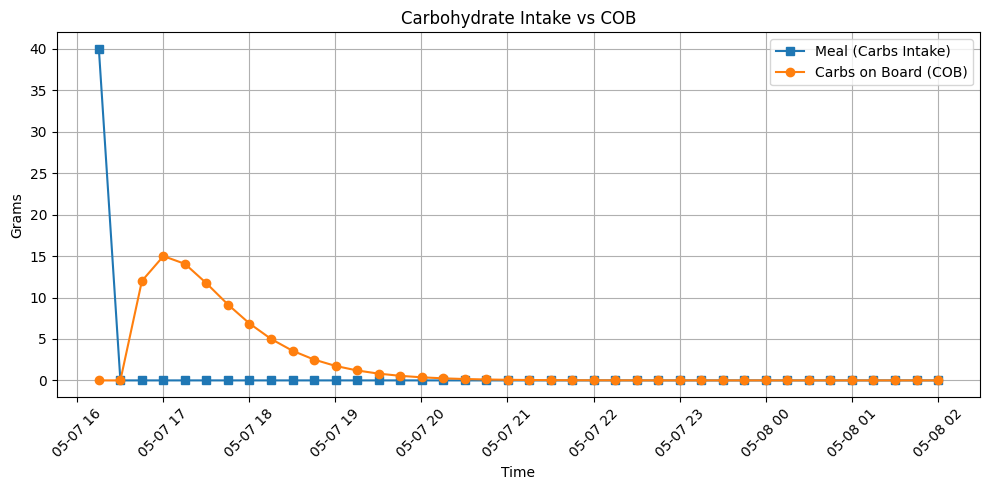

In [48]:
# === PLOT 1: Meal vs COB ===
plt.figure(figsize=(10, 5))
plt.plot(df_kinetics['Time'], df_kinetics['Carbohydrates'], label='Meal (Carbs Intake)', marker='s')
plt.plot(df_kinetics['Time'], df_kinetics['COB'], label='Carbs on Board (COB)', marker='o')
plt.xlabel('Time')
plt.ylabel('Grams')
plt.title('Carbohydrate Intake vs COB')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




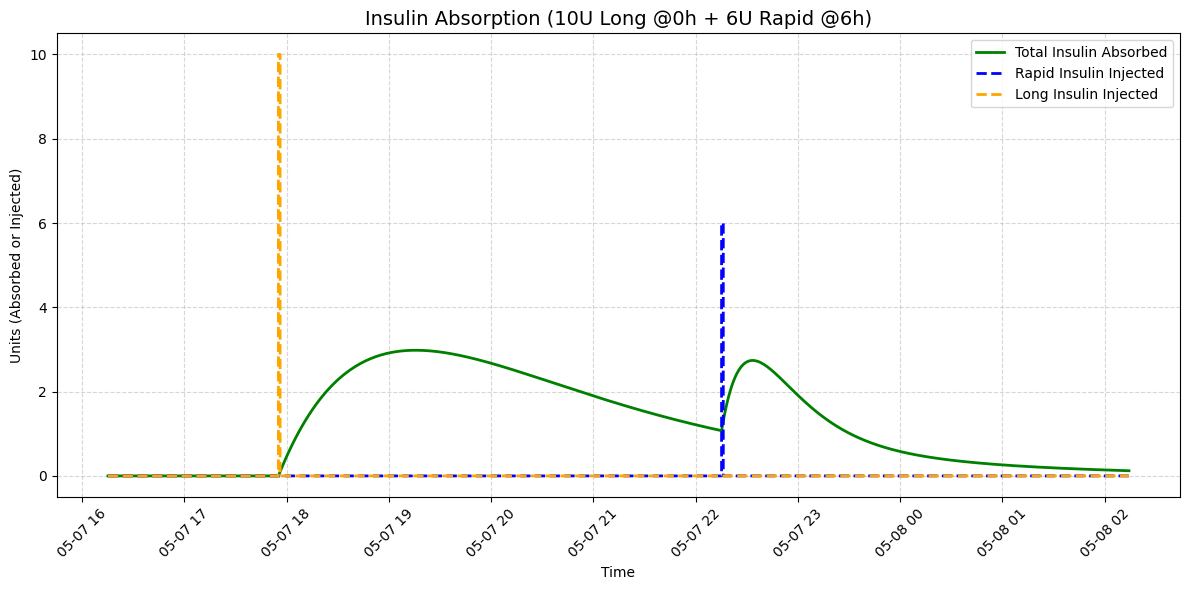

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Time setup
dt = 1  # 1-minute resolution
total_minutes = 10 * 60
steps = total_minutes // dt
time_range = [datetime.now() + timedelta(minutes=i*dt) for i in range(steps)]

# Injection profile (hardcoded)
rapid_injection = np.zeros(steps)
long_injection = np.zeros(steps)
rapid_injection[360] = 6    # inject 6U rapid at 6h
long_injection[100] = 10      # inject 10U long at t=0

# 2-compartment absorption model
def insulin_absorption_model(injection_array, ka1, ka2):
    Q1 = np.zeros(steps)
    Q2 = np.zeros(steps)
    for i in range(1, steps):
        inj = injection_array[i]
        dQ1 = (-ka1 * Q1[i-1] + inj) * dt
        dQ2 = (ka1 * Q1[i-1] - ka2 * Q2[i-1]) * dt
        Q1[i] = Q1[i-1] + dQ1
        Q2[i] = Q2[i-1] + dQ2
    return Q2

# Parameters
ka1_rapid, ka2_rapid = 0.04, 0.06
ka1_long, ka2_long = 0.01, 0.015

# Simulate absorption
rapid_abs = insulin_absorption_model(rapid_injection, ka1_rapid, ka2_rapid)
long_abs = insulin_absorption_model(long_injection, ka1_long, ka2_long)
total_abs = rapid_abs + long_abs

# Plot total absorption + injections
plt.figure(figsize=(12, 6))
plt.plot(time_range, total_abs, label='Total Insulin Absorbed', color='green', linewidth=2)
plt.step(time_range, rapid_injection, label='Rapid Insulin Injected', where='post', linestyle='--', color='blue', linewidth=2)
plt.step(time_range, long_injection, label='Long Insulin Injected', where='post', linestyle='--', color='orange', linewidth=2)

plt.title("Insulin Absorption (10U Long @0h + 6U Rapid @6h)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Units (Absorbed or Injected)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
